In [1]:

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten
import matplotlib.pyplot as plt

from keras.layers import Conv1D, UpSampling1D,BatchNormalization, Activation,LeakyReLU,GlobalAveragePooling1D,GlobalMaxPooling1D,Dropout
from keras.layers import MaxPooling1D,AveragePooling1D,Multiply, Reshape, Input, Concatenate,Add
from keras.models import Model

from sklearn import preprocessing


from sklearn.metrics import mean_squared_error as MSE



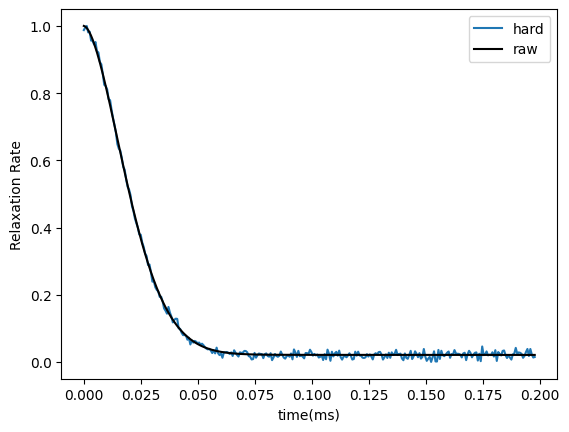

In [2]:
timeline = np.arange(310)*0.00064


def normalization(data):
    nomalized =(data-np.min(data))/(np.max(data)-np.min(data))
    return nomalized

def make_datas(timeline):#モデルの学習用データを作る関数
 
    #T2を決定
    T2_0=np.random.uniform(0.0200,0.035)
    T2_1=np.random.uniform(0.031,0.07)
    T2_2=np.random.uniform(0.07,0.145)
    T2_3=np.random.uniform(0.145,0.195)#ここは3成分に修正

    #ワイブル係数を決定
    W_0=1 + np.random.uniform(0,1)
    #存在比を決定
    a=np.random.uniform(0,100)
    b=np.random.uniform(0,0.5)
    c=np.random.uniform(0,1)
    d=np.random.uniform(0,1)


    abcd_sum=a+b+c+d

    a=a/abcd_sum
    b=b/abcd_sum
    c=c/abcd_sum
    d=d/abcd_sum


    #print(f"a:{a},b:{b},c:{c}")
    #print(f"T2_0:{T2_0},T2_1:{T2_1},T2_2:{T2_2}")
    #print(f"W_0{W_0}")
    raw_data = a*np.exp(-W_0*(timeline/T2_0)**W_0)+b*np.exp(np.array(timeline)/(-T2_1))+c*np.exp(timeline/(-T2_2))+d*np.exp(timeline*0.01/(-T2_3))
    params=np.array([a,b,c,d,T2_0,T2_1,T2_2,T2_3,W_0])


    #正規分布で出力されるノイズ項に対して異なる定数をかけて積算の異なるデータの再現をしている
    noise_rate=0.2
    ramdom_noise_rate=np.random.uniform(0,0.05)

    #生成した曲線にノイズ項を付与する
    noisd_data = raw_data + (np.random.randn(len(timeline))*noise_rate*ramdom_noise_rate)

    con_array=np.stack((raw_data,noisd_data))
    con_array = normalization(con_array)

    raw_data = con_array[0,: ]
    noisd_data = con_array[1,:]

    return raw_data,noisd_data


raw_data,noisd_data,=make_datas(timeline)
plt.plot(timeline, noisd_data,label="hard")
plt.plot(timeline, raw_data,label="raw",color="black")

#生成した曲線の様子を600点目まで確認。横軸時間、縦軸データで表示

plt.xlabel("time(ms)")
plt.ylabel("Relaxation Rate")
plt.legend()
plt.show()


(30000, 310)
(30000, 310)


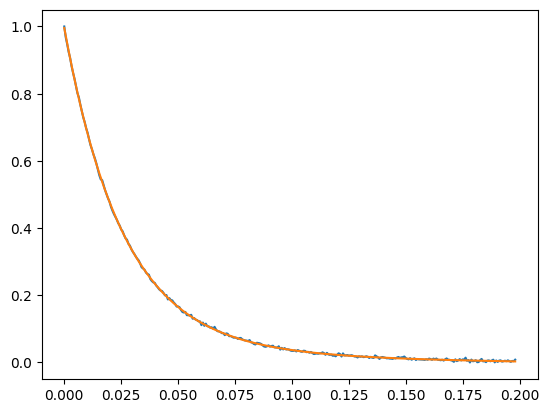

(30000, 310, 1)
(30000, 310, 1)


In [13]:
output_data =[] #ノイズを付与する前のデータが格納されている配列。正解データに相当
input_data = []#CNNの問題データを保持する配列。ここではノイズの強いデータが代入されている


data_size=30000
for n in range(data_size):
    raw,noised_data=make_datas(timeline)
    input_data.append(noised_data)
    output_data.append(raw)


#ここまででlist型オブジェクトにtrainまたはtestのnp.arrayが格納されている

input_data = np.array(input_data)#listにnp.arrayを格納している状態を二次元np.arrayに変更する
output_data = np.array(output_data)

print(input_data.shape)
print(output_data.shape)

plt.plot(timeline,input_data[0,:])
plt.plot(timeline,output_data[0,:])
plt.show()

train_X = np.reshape(input_data, (-1, len(timeline), 1))#強ノイズデータ
No_noise=np.reshape(output_data, (-1,len(timeline), 1))

print(train_X.shape)
print(No_noise.shape)


In [17]:
#残差ブロック部分の処理を宣言

class ResidualBlock(tf.keras.layers.Layer):
  #コンストラクタを宣言、フィルター数、カーネルサイズは任意で指定する。ストライドは1で固定
    def __init__(self,filters,kernel_size,strides=1,**kwargs):
        super(ResidualBlock,self).__init__()
        self.conv1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=strides,padding="same",activation="relu")
        self.bn1 = BatchNormalization()
        self.conv2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=strides,padding="same",activation="relu")
        self.bn2 = BatchNormalization()
        self.conv3 = Conv1D(filters=filters,kernel_size=kernel_size,strides=strides,padding="same",activation="relu")
        self.bn3 = BatchNormalization()
        self.conv4 = Conv1D(filters=filters,kernel_size=kernel_size,strides=strides,padding="same",activation="relu")
        self.bn4 = BatchNormalization()


        #ショートカット接続のために1次元畳み込みレイヤーを挟んでフィルター数をそろえる
        self.dense_SE1=tf.keras.layers.Dense(filters,activation="relu")
        self.dense_SE2=tf.keras.layers.Dense(filters,activation="sigmoid")
        self.conv1x1=Conv1D(filters=filters,kernel_size=1,strides=strides,padding="same",activation="relu")
        self.global_average_pooling=GlobalAveragePooling1D()



    def call(self,inputs):#コンストラクタで宣言した関数を使って残差接続のサブルーチンを設計する
        shortcut=self.global_average_pooling(inputs)
        shortcut=self.dense_SE1(shortcut)#残差接続する分を控えておく
        shortcut=self.dense_SE2(shortcut)
        reshaped_inputs=self.conv1x1(inputs)
        shortcut=Multiply()([shortcut,reshaped_inputs])


        x = self.conv1(inputs)#最初の畳み込み
        x = self.bn1(x)#バッチ正規化
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)

        x += shortcut#ショートカット接続

        return x




class NoiseGate(tf.keras.layers.Layer):#入力のノイズレベルを評価するよ！
    def __init__(self,kernel_size,strides=1,**kwargs):
        super(NoiseGate,self).__init__()
        self.conv1=Conv1D(filters=16,kernel_size=kernel_size,strides=strides,padding="same",activation="relu")
        self.conv2=Conv1D(filters=32,kernel_size=kernel_size,strides=strides,padding="same",activation="relu")
        self.conv3=Conv1D(filters=64,kernel_size=kernel_size,strides=strides,padding="same",activation="relu")
        self.conv4=Conv1D(filters=1,kernel_size=kernel_size,strides=strides,padding="same",activation="sigmoid")


    def call(self,inputs):
        x=self.conv1(inputs)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        return x


class MyResNetModel(tf.keras.Model):
    def __init__(self,**kwargs):
        super(MyResNetModel,self).__init__()#記法の意味が分からない…。親クラスの継承がうまくいくおまじない
        #フィルター数を段階的に増やしながら残差ブロックのインスタンスを生成
        self.average_pooling=AveragePooling1D(pool_size=2,padding="valid")
        self.max_pooling=MaxPooling1D(pool_size=2,padding="valid")
        self.residual_block1=ResidualBlock(filters=32,kernel_size=5)#ResidualBlock classのコンストラクタを呼び出している
        #self.residual_block2=ResidualBlock(filters=64,kernel_size=5)
        #self.residual_block3=ResidualBlock(filters=64,kernel_size=5)
        self.residual_block4=ResidualBlock(filters=64,kernel_size=5)
        self.residual_block5=ResidualBlock(filters=128,kernel_size=5)
        self.residual_block6=ResidualBlock(filters=256,kernel_size=5)

   

        self.GAP=GlobalAveragePooling1D()
        #self.dense1 = Dense(8192,activation="relu")
        self.dense2 = Dense(100,activation="relu")
        self.dense3 = Dense(200,activation="relu")
        self.dense4 = Dense(310,activation="linear")

        self.noise_gate=NoiseGate(kernel_size=5)


    def call(self,inputs):

        x = self.residual_block1(inputs)
        x = self.average_pooling(x)
        x = self.residual_block4(x)

        x = self.max_pooling(x)
        x = self.residual_block5(x)
        map = self.residual_block6(x)
      

        gap=self.GAP(map)

        x = self.dense2(gap)
        x = self.dense3(x)
        x = self.dense4(x)


        noise_gate=self.noise_gate(inputs)

        noise_gate = tf.squeeze(noise_gate, axis=-1)  # (batch_size, length)
        inputs = tf.squeeze(inputs, axis=-1)  # (batch_size, length)

        output1=Multiply()([noise_gate, inputs])
        output2=Multiply()([1-noise_gate, x])
        x=Add()([output1,output2])
        

        return x,gap,map


    def get_config(self):
        config = super(MyResNetModel, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)



model = MyResNetModel()
your_input_length=311
your_input_channels=1
model.build((None, your_input_length, your_input_channels))
model.compile(optimizer="adam", loss=["mse",None,None],loss_weights=[1,0,0])





c:\プログラミング\python_env\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'my_res_net_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [18]:
epochs = 30 #エポック数を定義
tf.keras.backend.clear_session()

history = model.fit(train_X[:, :, :], No_noise[:, :, :], validation_split=0.1 , epochs = epochs )

#validation_split=0.1は学習データの末尾の10％を検証用にカットする引数。交差検証を行えるわけではない
#10000点の全体のうち9000点で学習している
model.summary()

Epoch 1/30
 17/844 ━━━━━━━━━━━━━━━━━━━━ 1:32 111ms/step - loss: 0.0114

KeyboardInterrupt: 

In [ ]:
plt.plot(range(epochs), history.history['loss'], label='train')
plt.plot(range(epochs), history.history['val_loss'], label='test')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
#新しい方
start = int(data_size*0.9)
pred=[]


res1 = model.predict(train_X[start:, :, :])[0]

print(res1.shape)

In [ ]:
#新しい方
for i in range(40):
    plt.plot(figsize=(100, 60))
    plt.title(f"{i+1}")

    plt.plot(timeline, train_X[i+start,:, :].reshape(-1), label='noise')
    plt.plot(timeline, No_noise[i+start,:, :].reshape(-1), label='No_noise')
    plt.plot(timeline, res1[i, :].reshape(-1), label='predict',color="black")

    plt.legend()
    plt.show()


In [ ]:
for i in range(40):
    plt.plot(figsize=(100, 60))
    plt.title(f"{i+1}_(log)")

    plt.plot(timeline, np.log(train_X[i+start,:, :].reshape(-1)), label='noise')
    plt.plot(timeline, np.log(No_noise[i+start,:, :].reshape(-1)), label='No_noise')
    plt.plot(timeline, np.log(res1[i, :].reshape(-1)), label='predict',color="black")

    plt.legend()
    plt.show()